In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('dataset2.csv', engine='python', skipfooter=3)
print(data)


       Month             A
0    2004-01  7.863847e+06
1    2004-02  7.787864e+06
2    2004-03  7.579078e+06
3    2004-04  7.283592e+06
4    2004-05  6.926078e+06
5    2004-06  7.084159e+06
6    2004-07  8.320856e+06
7    2004-08  8.545421e+06
8    2004-09  7.315812e+06
9    2004-10  7.216689e+06
10   2004-11  7.566827e+06
11   2004-12  8.108930e+06
12   2005-01  8.622949e+06
13   2005-02  8.447704e+06
14   2005-03  8.341744e+06
15   2005-04  7.725420e+06
16   2005-05  7.418659e+06
17   2005-06  7.748380e+06
18   2005-07  8.585022e+06
19   2005-08  8.852915e+06
20   2005-09  8.236630e+06
21   2005-10  7.695856e+06
22   2005-11  8.155174e+06
23   2005-12  9.076439e+06
24   2006-01  8.974909e+06
25   2006-02  9.058129e+06
26   2006-03  8.678714e+06
27   2006-04  8.239455e+06
28   2006-05  7.835787e+06
29   2006-06  7.927267e+06
..       ...           ...
141  2015-10  1.190501e+07
142  2015-11  1.276607e+07
143  2015-12  1.434440e+07
144  2016-01  1.587174e+07
145  2016-02  1.531668e+07
1

In [3]:
data['Month']=pd.to_datetime(data['Month'], format="%Y-%m-%d")
data.set_index(['Month'], inplace=True)
type(data)
print(data.head())

                      A
Month                  
2004-01-01  7863847.258
2004-02-01  7787863.828
2004-03-01  7579078.065
2004-04-01  7283591.967
2004-05-01  6926077.677


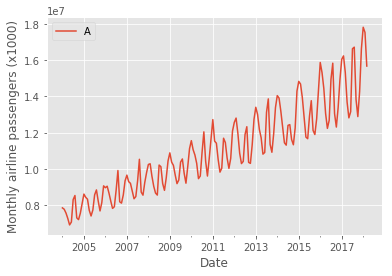

In [4]:
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

In [5]:
q = d = range(0, 2)
p = range(0, 4)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
train_data = data['2004-01-01':'2017-12-01']
test_data = data['2018-01-01':'2018-06-01']

In [7]:
warnings.filterwarnings("ignore") 

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 3330.974737601972 for model SARIMAX(3, 1, 1)x(3, 1, 0, 12)


In [9]:
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

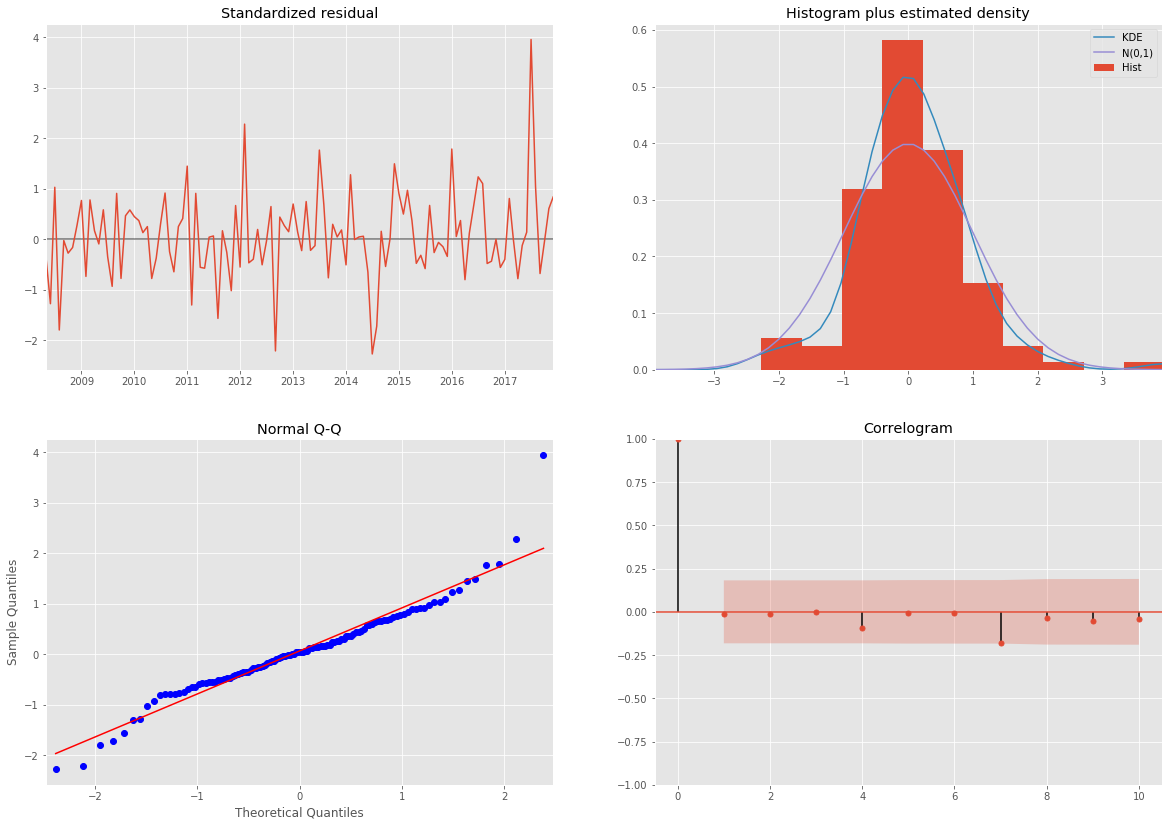

In [10]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [11]:
pred0 = results.get_prediction(start='2018-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [12]:
pred1 = results.get_prediction(start='2018-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [13]:
pred2 = results.get_forecast('2028-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2017-06-01':'2018-06-01'])

2018-01-01    1.739870e+07
2018-02-01    1.718850e+07
2018-03-01    1.620403e+07
2018-04-01    1.483818e+07
2018-05-01    1.391284e+07
2018-06-01    1.410294e+07
Freq: MS, dtype: float64


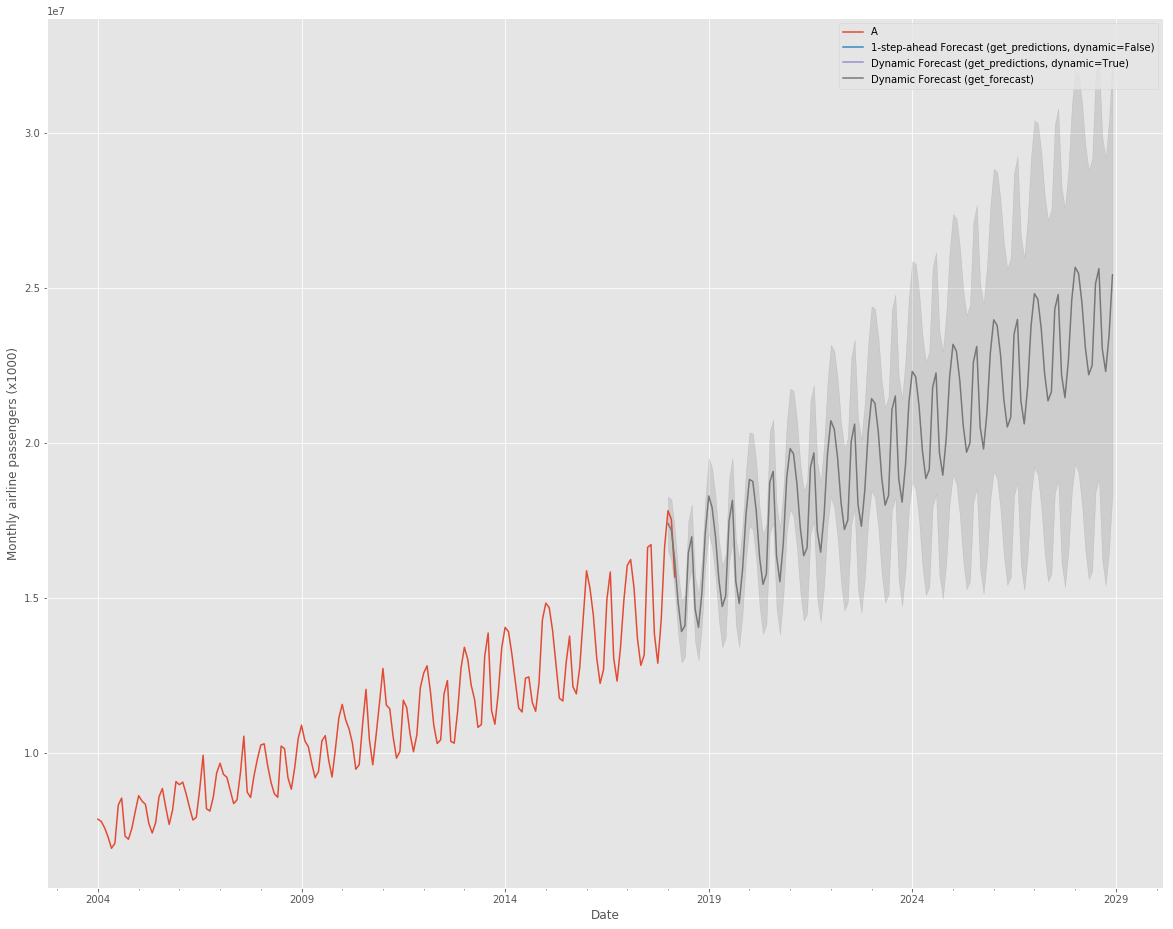

In [14]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()